In [1]:
import pandas as pd
import numpy as np
import math
import concurrent.futures
import itertools
import heapq
from collections import defaultdict
import multiprocessing
from functools import partial
from concurrent.futures import ThreadPoolExecutor



# Assignment 1

In [2]:
folder = "./ml-latest-small/"

In [3]:
rating_source = pd.read_csv(folder + "ratings.csv", dtype='object')
rating_source

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [5]:
rating_source[:100]

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
95,1,1445,3.0,964984112
96,1,1473,4.0,964980875
97,1,1500,4.0,964980985
98,1,1517,5.0,964981107


In [6]:
user_ratings_dict = {}
for userId, group in rating_source.groupby('userId'):
    user_ratings_dict[userId] = list(zip(group['movieId'], group['rating']))

In [ ]:
def somma():
    return 1 + 1

### Definition of User Similarity


In [7]:
def get_common_movies_ratings(user1, user2, dataframe):
    movies_user1 = set(dataframe[dataframe['userId'] == user1]['movieId'])
    movies_user2 = set(dataframe[dataframe['userId'] == user2]['movieId'])

    common_movies = movies_user1.intersection(movies_user2)

    common_movies_dict = {}
    for movie in common_movies:
        rating_user1 = dataframe[(dataframe['userId'] == user1) & (dataframe['movieId'] == movie)]['rating'].values[0]
        rating_user2 = dataframe[(dataframe['userId'] == user2) & (dataframe['movieId'] == movie)]['rating'].values[0]
        common_movies_dict[movie] = (rating_user1, rating_user2)

    return common_movies_dict

In [8]:
def user_similarity_2(user_a, user_b, rating_source):
    movies_user1 = set(rating_source[rating_source['userId'] == user_a]['movieId'])
    movies_user2 = set(rating_source[rating_source['userId'] == user_b]['movieId'])

    common_movies = movies_user1.intersection(movies_user2)
    if(len(common_movies)==0):
        return -1.0

    ratings_user_a, ratings_user_b = [], []

    for movie in common_movies:
        rating_user_a = float(rating_source[(rating_source['userId'] == user_a) & (rating_source['movieId'] == movie)]['rating'].values[0])
        rating_user_b= float(rating_source[(rating_source['userId'] == user_b) & (rating_source['movieId'] == movie)]['rating'].values[0])

        ratings_user_a.append(rating_user_a)
        ratings_user_b.append(rating_user_b)
    
    mean_rating_a = np.mean([float(rating) for rating in rating_source[(rating_source['userId'] == user_a)]['rating']])
    mean_rating_b = np.mean([float(rating) for rating in rating_source[(rating_source['userId'] == user_b)]['rating']])

    numerator = np.sum((np.array(ratings_user_a) - mean_rating_a) * (np.array(ratings_user_b) - mean_rating_b))
    denominator_a = np.sqrt(np.sum((np.array(ratings_user_a) - mean_rating_a)**2))
    denominator_b = np.sqrt(np.sum((np.array(ratings_user_b) - mean_rating_b)**2))

    similarity = numerator / (denominator_a * denominator_b) if denominator_a * denominator_b != 0 else 0
    return similarity

In [9]:
def mean_rating(user, rating_source):
    ratings_user = [float(rating) for rating in rating_source[(rating_source['userId'] == user)]['rating']]
    mean_rating = np.mean(ratings_user)
    
    return mean_rating

In [10]:
def user_similarity(user_a, user_b, rating_source):
    movie_intersection_a_b = get_common_movies_ratings(user_a, user_b, rating_source)
    if(len(movie_intersection_a_b)==0):
        return -1.0

    ratings_user_a, ratings_user_b = zip(*[(float(ra), float(rb)) for ra, rb in movie_intersection_a_b.values()])
    # ratings_user_a = [float(rating) for rating in rating_source[(rating_source['userId'] == user_a)]['rating']]
    # ratings_user_b = [float(rating) for rating in rating_source[(rating_source['userId'] == user_b)]['rating']]
    mean_rating_a = mean_rating(user_a,rating_source)
    mean_rating_b = mean_rating(user_b,rating_source)

    numerator = np.sum((np.array(ratings_user_a) - mean_rating_a) * (np.array(ratings_user_b) - mean_rating_b))
    denominator_a = np.sqrt(np.sum((np.array(ratings_user_a) - mean_rating_a)**2))
    denominator_b = np.sqrt(np.sum((np.array(ratings_user_b) - mean_rating_b)**2))

    similarity = numerator / (denominator_a * denominator_b) if denominator_a * denominator_b != 0 else 0

    return similarity

In [104]:
value = user_similarity("1","19",rating_source)
value

0.22574845026891868

In [100]:
value = user_similarity_2("1","19",rating_source)
value

0.22574845026891868

### Method's definition for making prediction

In [11]:
def get_ratings_for_movie(movie_id, dataframe):
    ratings_for_movie = []
    movie_data = dataframe[dataframe['movieId'] == movie_id]
    for _, row in movie_data.iterrows():
        ratings_for_movie.append((row['userId'], row['rating']))
    return ratings_for_movie

In [12]:
def get_rating_for_user_movie(user_id, movie_id, dataframe):
    rating = dataframe[(dataframe['userId'] == user_id) & (dataframe['movieId'] == movie_id)]['rating'].values
    return rating[0] if len(rating) > 0 else None

In [13]:
def get_users_for_movie(movieId, rating_source):
    users = rating_source[rating_source['movieId'] == movieId]['userId'].tolist()
    return users

In [14]:
def making_prediction(user_a, movieId, rating_source):
    mean_rating_a = mean_rating(user_a, rating_source)
    
    user_for_movie = get_users_for_movie(movieId, rating_source)
    numerator = 0
    denominator = 0

    for user_b in user_for_movie:
        if(user_b != user_a):
            print(user_b)
            rating_for_movie_b = float(get_rating_for_user_movie(user_b, movieId, rating_source))
            mean_rating_b = mean_rating(user_b, rating_source)
            similarity = user_similarity(user_a, user_b, rating_source)
            numerator += similarity * (rating_for_movie_b - mean_rating_b)
            denominator += similarity

    prediction = mean_rating_a + (numerator / abs(denominator)) if abs(denominator) > 0 else 0

    return prediction            

In [73]:
result = making_prediction("1", "2", rating_source)
result

6
8
18
19
20
21
27
51
62
68
82
91
93
94
103
104
107
112
117
122
125
135
140
144
149
153
160
169
177
186
202
217
219
221
222
226
230
232
240
249
259
274
276
284
288
294
298
299
304
305
307
308
318
321
322
323
330
347
353
357
359
373
380
381
395
411
414
425
426
432
434
436
446
447
448
458
470
474
475
476
477
480
482
483
484
489
497
501
512
517
523
525
527
534
559
561
563
566
570
573
586
590
592
594
599
600
602
604
605
608


3.5973949736369373

In [15]:
def calculate_prediction(user_a, user_b, movieId, rating_source):
    rating_for_movie_b = float(get_rating_for_user_movie(user_b, movieId, rating_source))
    mean_rating_b = mean_rating(user_b, rating_source)
    similarity = user_similarity(user_a, user_b, rating_source)
    return similarity * (rating_for_movie_b - mean_rating_b), similarity

def making_prediction_optimized(user_a, movieId, rating_source):
    mean_rating_a = mean_rating(user_a, rating_source)
    
    user_rating_for_movie = get_ratings_for_movie(movieId, rating_source)
    numerator = 0
    denominator = 0

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for user_b, _ in user_rating_for_movie:
            if user_b != user_a:
                futures.append(executor.submit(calculate_prediction, user_a, user_b, movieId, rating_source))
        
        for future in concurrent.futures.as_completed(futures):
            result, similarity = future.result()
            numerator += result
            denominator += similarity

    prediction = mean_rating_a + (numerator / abs(denominator)) if abs(denominator) > 0 else 0

    return prediction

In [101]:
result = making_prediction_optimized("1", "3", rating_source)
result

7
4.366379310344827
13
4.366379310344827
10
4.366379310344827
22
4.366379310344827
17
4.366379310344827
22
4.366379310344827
20
4.366379310344827
7
4.366379310344827
26
4.366379310344827
30
4.366379310344827
29
4.366379310344827
10
4.366379310344827
12
4.366379310344827
33
4.366379310344827
339

4.366379310344827
4.366379310344827
25
4.366379310344827
41
4.366379310344827
4014

4.366379310344827
4.366379310344827
21
4.366379310344827
14
4.366379310344827
9
4.366379310344827
6
4.366379310344827
25
4.366379310344827
14
4.366379310344827
6
4.366379310344827
22
4.366379310344827
79
4.366379310344827
21
4.366379310344827
84
4.366379310344827
38
4.366379310344827
117
4.366379310344827
81
4.366379310344827
35
4.366379310344827
123
4.366379310344827
120
4.366379310344827
98
4.366379310344827
111
4.366379310344827
114
4.366379310344827
107
4.366379310344827
98
4.366379310344827
154
4.366379310344827
99
4.366379310344827
154
4.366379310344827
139
4.366379310344827
130
4.366379310344827
128
4.366

3.1267005200695364

In [27]:
result

1.8431566712625378

In [46]:
result = making_prediction("1", "3", rating_source)

6
19
32
42
43
44
51
58
64
68
91
100
102
116
117
150
151
169
179
217
226
240
269
270
288
289
294
302
307
308
321
330
337
368
410
414
448
456
470
477
480
492
501
544
552
555
588
590
594
599
608


In [31]:
result

3.1267005200695364

### Top-10 most similar user and most relevant movies

#### Top k user

In [16]:
def get_top_k_user_fast(user_a, rating_source, k):
    results_for_similarity = {}
    users_except = rating_source[rating_source['userId'] != user_a]['userId'].unique().tolist()

    for user_b in users_except:
        result = user_similarity(user_a,user_b,rating_source)
        print("user_a = {}".format(user_a) + " | user_b = " + user_b + " ---> similarity = {}".format(result))
        if(results_for_similarity.__contains__(result)):
            print(results_for_similarity.get(-1.0))
            values = list(results_for_similarity.get(result))
            values.append(user_b)
            results_for_similarity[result] = values
        else:
            results_for_similarity[result] = [user_b]
    
    results_for_similarity_ordered = dict(sorted(results_for_similarity.items(), reverse=True))
    top_k_user = []
    for key, value in results_for_similarity_ordered.items():
        for user in value:
            if(len(top_k_user) != k):
                top_k_user.append((user, key))
            else:
                break
    
    return top_k_user


In [108]:
def get_top_k_user_slow(user_a, rating_source, k):
    top_k_user = []
    users_except = rating_source[rating_source['userId'] != user_a]['userId'].unique().tolist()

    for user_b in users_except:
        result = user_similarity(user_a,user_b,rating_source)
        print("user_a = {}".format(user_a) + " | user_b = " + user_b + " ---> similarity = {}".format(result))

        if(len(top_k_user) <= k):
            top_k_user.append((user_b, result))
        
        else:
            min_top_k_user = min(top_k_user, key=lambda x: x[1])
            if(min_top_k_user[1] < result):
                top_k_user.remove(min_top_k_user)
                top_k_user.append((user_b, result))
    
    return top_k_user


In [106]:
result = get_top_k_user_fast("19",rating_source, 10)

user_a = 1 | user_b = 1 ---> similarity = 0.22574845026891868
user_a = 1 | user_b = 2 ---> similarity = -0.21000395585932924
user_a = 1 | user_b = 3 ---> similarity = -0.45885729582989904
user_a = 1 | user_b = 4 ---> similarity = 0.03854044948757061
user_a = 1 | user_b = 5 ---> similarity = -0.13356114876060246
user_a = 1 | user_b = 6 ---> similarity = 0.25183265523369486
user_a = 1 | user_b = 7 ---> similarity = 0.2563355903304139
user_a = 1 | user_b = 8 ---> similarity = 0.07627989583634169
user_a = 1 | user_b = 9 ---> similarity = 0.9574127171101997
user_a = 1 | user_b = 10 ---> similarity = -0.6793985780818487
user_a = 1 | user_b = 11 ---> similarity = -0.017566777118630448
user_a = 1 | user_b = 12 ---> similarity = -0.37381455646209594
user_a = 1 | user_b = 13 ---> similarity = 0.47905901342235585
user_a = 1 | user_b = 14 ---> similarity = -0.03556094282042245
user_a = 1 | user_b = 15 ---> similarity = 0.1541760514991933
user_a = 1 | user_b = 16 ---> similarity = -0.13637291090790

In [107]:
result

[('65', 1.0),
 ('253', 1.0),
 ('338', 1.0),
 ('106', 0.986071473279509),
 ('258', 0.9656713482332208),
 ('9', 0.9574127171101997),
 ('358', 0.8827912816847923),
 ('77', 0.8723057851465691),
 ('114', 0.8386833016493874),
 ('547', 0.8382535825674761)]

In [63]:
result = get_top_k_user_slow("1", rating_source, 10)

user_a = 1 | user_b = 2 ---> similarity = 0.9999999999999998
user_a = 1 | user_b = 3 ---> similarity = 0.011225168459991653
user_a = 1 | user_b = 4 ---> similarity = 0.21042328781675118
user_a = 1 | user_b = 5 ---> similarity = 0.19472139278694267
user_a = 1 | user_b = 6 ---> similarity = -0.3020187823310265
user_a = 1 | user_b = 7 ---> similarity = -0.04664156383054847
user_a = 1 | user_b = 8 ---> similarity = 0.4265612329426458
user_a = 1 | user_b = 9 ---> similarity = 0.35473856827532246
user_a = 1 | user_b = 10 ---> similarity = -0.15121755406386425
user_a = 1 | user_b = 11 ---> similarity = -0.4499572307079907
user_a = 1 | user_b = 12 ---> similarity = 1.0
user_a = 1 | user_b = 13 ---> similarity = 0.947878845842068
user_a = 1 | user_b = 14 ---> similarity = 0.2253535048415333
user_a = 1 | user_b = 15 ---> similarity = 0.31204846354219923
user_a = 1 | user_b = 16 ---> similarity = 0.0496340842921011
user_a = 1 | user_b = 17 ---> similarity = 0.19844179978497956
user_a = 1 | user_b

In [64]:
result

[('2', 0.9999999999999998),
 ('12', 1.0),
 ('77', 1.0000000000000002),
 ('85', 1.0),
 ('146', 0.9990496408681655),
 ('253', 1.0),
 ('278', 0.9710607611177227),
 ('291', 1.0),
 ('358', 1.0),
 ('388', 1.0),
 ('550', 0.9500648497978605)]

#### Top k movie

In [17]:
def get_unowned_movie_ids(user_id, dataframe):
    # Ottenere tutti i movieId unici presenti nel DataFrame
    all_movie_ids = dataframe['movieId'].unique()
    
    # Ottenere i movieId posseduti dall'utente specifico
    user_movie_ids = dataframe[dataframe['userId'] == user_id]['movieId'].unique()
    
    # Rimuovere i movieId posseduti dall'utente dalla lista di tutti i movieId
    unowned_movie_ids = [movie_id for movie_id in all_movie_ids if movie_id not in user_movie_ids]
    
    return unowned_movie_ids

In [18]:
def get_top_k_movie_fast(user_a, rating_source, k):
    results_for_prediction = {}
    unowned_movies = get_unowned_movie_ids(user_a, rating_source)
    
    print(len(unowned_movies))
    i = 0

    for movieId in unowned_movies:
        prediction = making_prediction_optimized(user_a, movieId, rating_source)

        i += 1
        print(str(i) + ") MovieId: {}".format(movieId) + " ---> prediction = {}".format(prediction))
        if(results_for_prediction.__contains__(prediction)):
            values = list(results_for_prediction.get(prediction))
            values.append(movieId)
            results_for_prediction[prediction] = values
        else:
            results_for_prediction[prediction] = [movieId]
    
    results_for_prediction_ordered = dict(sorted(results_for_prediction.items(), reverse=True))
    top_k_movie = []
    for key, value in results_for_prediction_ordered.items():
        for movieId in value:
            if(len(top_k_movie) != k):
                top_k_movie.append((movieId, key))
            else:
                break
    
    return top_k_movie


In [19]:
def get_top_k_movie_fast_2(user_a, rating_source, k):
    results_for_prediction = {}
    unowned_movies = get_unowned_movie_ids(user_a, rating_source)
    
    print(len(unowned_movies))
    i = 0

    def predict_and_update(movieId):
        prediction = making_prediction_optimized(user_a, movieId, rating_source)
        return (prediction, movieId)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_movieId = {executor.submit(predict_and_update, movieId): movieId for movieId in unowned_movies}
        for future in concurrent.futures.as_completed(future_to_movieId):
            movieId = future_to_movieId[future]
            try:
                prediction = future.result()
                i += 1
                print(str(i) + ") MovieId: {}".format(movieId) + " ---> prediction = {}".format(prediction))
                if prediction in results_for_prediction:
                    results_for_prediction[prediction].append(movieId)
                else:
                    results_for_prediction[prediction] = [movieId]
            except Exception as e:
                print(f"An error occurred for movieId {movieId}: {e}")

    results_for_prediction_ordered = dict(sorted(results_for_prediction.items(), reverse=True))
    top_k_movie = []
    for key, value in results_for_prediction_ordered.items():
        for movieId in value:
            if len(top_k_movie) != k:
                top_k_movie.append((movieId, key))
            else:
                break
    
    return top_k_movie

In [34]:
movies = get_top_k_movie_fast_2("19", rating_source, 10)

9021


### New similarity

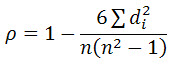

In [20]:
def user_similarity_spearman(user_a, user_b, rating_source, p):
    movies_user1 = set(rating_source[rating_source['userId'] == user_a]['movieId'])
    movies_user2 = set(rating_source[rating_source['userId'] == user_b]['movieId'])

    common_movies = movies_user1.intersection(movies_user2)
    if(len(common_movies)==0):
        return -1.0

    ratings_user_a, ratings_user_b = [], []

    for movie in common_movies:
        rating_user_a = float(rating_source[(rating_source['userId'] == user_a) & (rating_source['movieId'] == movie)]['rating'].values[0])
        rating_user_b= float(rating_source[(rating_source['userId'] == user_b) & (rating_source['movieId'] == movie)]['rating'].values[0])

        ratings_user_a.append(rating_user_a)
        ratings_user_b.append(rating_user_b)
    
    numerator = 0
    n = 0

    for rating_a in ratings_user_a:
        for rating_b in ratings_user_b:
            print("Rating A: {}, Rating B: {}".format(rating_a, rating_b))
            numerator += (rating_a - rating_b)**2
            n += 1

    
    result = 1-((6*numerator)/(n*(n**2 -1)))
    return result

In [21]:
def user_similarity_spearman_2(user_a, user_b, rating_source):
    movies_user1 = set(rating_source[rating_source['userId'] == user_a]['movieId'])
    movies_user2 = set(rating_source[rating_source['userId'] == user_b]['movieId'])

    common_movies = movies_user1.intersection(movies_user2)
    if not common_movies:
        return -1.0

    # Estrai le valutazioni per i film comuni
    ratings_user_a = rating_source[(rating_source['userId'] == user_a) & (rating_source['movieId'].isin(common_movies))].sort_values(by='movieId')['rating']
    ratings_user_b = rating_source[(rating_source['userId'] == user_b) & (rating_source['movieId'].isin(common_movies))].sort_values(by='movieId')['rating']

    # Calcola i ranghi delle valutazioni
    rank_user_a = ratings_user_a.rank(method='average')
    rank_user_b = ratings_user_b.rank(method='average')

    all_rank_pairs = list(itertools.product(rank_user_a, rank_user_b))
    n = len(all_rank_pairs)
    print(n)
    rank_diffs = np.array([ra - rb for ra, rb in all_rank_pairs])


    # Calcola il coefficiente di correlazione di Spearman
    spearman_corr = 1 - (6 * np.sum(rank_diffs**2)) / (n * (n**2 - 1))

    return spearman_corr

In [62]:
result = user_similarity_spearman_2("1", "19", rating_source)
result

15129


0.9999421403858132

In [31]:
result = user_similarity_spearman("1","2", rating_source, 3)
result

Rating A: 5.0, Rating B: 4.0
Rating A: 5.0, Rating B: 4.0
Rating A: 5.0, Rating B: 4.0
Rating A: 5.0, Rating B: 4.0


0.6

# Assignment 2

In [38]:
users = ["431", "576", "257"]

In [25]:
users = set(rating_source["userId"].values)

In [37]:
user_to_num_movies = []
for user in users:
    num_of_movies = rating_source[rating_source["userId"] == user]["movieId"].count()
    user_to_num_movies.append((user, num_of_movies))

user_to_num_movies_ordered = dict(sorted(user_to_num_movies, key=lambda item: item[1]))

user_to_num_movies_ordered

{'431': 20,
 '576': 20,
 '257': 20,
 '207': 20,
 '320': 20,
 '147': 20,
 '569': 20,
 '189': 20,
 '194': 20,
 '278': 20,
 '53': 20,
 '442': 20,
 '595': 20,
 '406': 20,
 '549': 21,
 '439': 21,
 '49': 21,
 '87': 21,
 '157': 21,
 '364': 21,
 '26': 21,
 '598': 21,
 '37': 21,
 '281': 21,
 '293': 21,
 '245': 21,
 '507': 21,
 '547': 21,
 '324': 21,
 '494': 22,
 '478': 22,
 '433': 22,
 '60': 22,
 '120': 22,
 '407': 22,
 '544': 22,
 '192': 22,
 '127': 22,
 '118': 22,
 '138': 22,
 '214': 22,
 '531': 22,
 '467': 22,
 '329': 23,
 '145': 23,
 '545': 23,
 '397': 23,
 '568': 23,
 '394': 23,
 '423': 23,
 '251': 23,
 '574': 23,
 '485': 23,
 '163': 23,
 '35': 23,
 '299': 23,
 '231': 24,
 '289': 24,
 '508': 24,
 '518': 24,
 '180': 24,
 '92': 24,
 '175': 24,
 '173': 25,
 '258': 25,
 '360': 25,
 '206': 25,
 '228': 25,
 '529': 25,
 '333': 25,
 '392': 25,
 '55': 25,
 '355': 26,
 '158': 26,
 '81': 26,
 '25': 26,
 '208': 26,
 '172': 26,
 '519': 26,
 '150': 26,
 '516': 26,
 '515': 26,
 '218': 26,
 '548': 26,
 '4

In [17]:
def get_movies_for_users(user_ids, rating_source):
    movies_sets = [set(rating_source[rating_source['userId'] == user_id]['movieId']) for user_id in user_ids]
    return movies_sets

In [18]:
def get_union_movies_for_users(user_ids, rating_source):
    movies_sets = get_movies_for_users(user_ids, rating_source)
    union_movies = set.union(*movies_sets)
    return union_movies

In [19]:
def average_aggregation(users, k, rating_source):
    movies = get_union_movies_for_users(users, rating_source)
    print(len(movies))
    movies_to_average_rating = {}
    for movie in movies: 
        sum_for_movie = 0
        for user in users:
            if(rating_source[(rating_source["userId"] == user) & (rating_source["movieId"] == movie)].empty):
                prediction_for_movie = making_prediction_optimized(user, movie, rating_source)
                sum_for_movie += prediction_for_movie
            else:
                sum_for_movie += float(rating_source[(rating_source["userId"] == user) & (rating_source["movieId"] == movie)]["rating"].values[0])
        
        movies_to_average_rating[movie] = (sum_for_movie/len(users))
        print("Movie: {} ----> Average Rating: {}".format(movie, movies_to_average_rating.get(movie)))
    
    movies_to_average_rating_ordered = dict(sorted(movies_to_average_rating.items(), key=lambda item: item[1], reverse=True))

    top_k_movies_recommend = dict(list(movies_to_average_rating_ordered.items())[:k])

    return top_k_movies_recommend 


In [41]:
def least_misery_aggregation(users, k, rating_source):
    movies = get_union_movies_for_users(users, rating_source)
    print(len(movies))
    movies_to_min_rating = {}
    for movie in movies: 
        ratings_for_movie = []
        for user in users:
            if(rating_source[(rating_source["userId"] == user) & (rating_source["movieId"] == movie)].empty):
                prediction_for_movie = making_prediction_optimized(user, movie, rating_source)
                ratings_for_movie.append(prediction_for_movie)
            else:
                ratings_for_movie.append(float(rating_source[(rating_source["userId"] == user) & (rating_source["movieId"] == movie)]["rating"].values[0]))
        
        movies_to_min_rating[movie] = min(ratings_for_movie)
        print("Movie: {} ----> Min Rating: {}".format(movie, movies_to_min_rating.get(movie)))
    
    movies_to_min_rating_ordered = dict(sorted(movies_to_min_rating.items(), key=lambda item: item[1], reverse=True))

    top_k_movies_recommend = dict(list(movies_to_min_rating_ordered.items())[:k])

    return top_k_movies_recommend 

In [39]:
result = average_aggregation(users, 10, rating_source)

59
Movie: 5952 ----> Average Rating: 2.748777341858626
Movie: 1233 ----> Average Rating: 3.2682395090112215
Movie: 849 ----> Average Rating: 0.42338148415539684
Movie: 1639 ----> Average Rating: 3.4292006666051145
Movie: 552 ----> Average Rating: 3.061193877295786
Movie: 327 ----> Average Rating: 2.669145016639867
Movie: 1500 ----> Average Rating: 2.588668783740928
Movie: 3996 ----> Average Rating: 3.3097964047793353
Movie: 2406 ----> Average Rating: 2.9537774116446798
Movie: 1345 ----> Average Rating: 4.5683289584976805
Movie: 2723 ----> Average Rating: 17.198963484841865
Movie: 2791 ----> Average Rating: 3.553931439275202
Movie: 172 ----> Average Rating: 1.9868220933235883
Movie: 903 ----> Average Rating: 3.27435740967754
Movie: 16 ----> Average Rating: 3.224074088299068
Movie: 1304 ----> Average Rating: 3.2350997473770673
Movie: 1278 ----> Average Rating: 3.5729499705849492
Movie: 1479 ----> Average Rating: -0.2060310565537753
Movie: 466 ----> Average Rating: 3.0945204378161493
Movi

In [40]:
result

{'2723': 17.198963484841865,
 '1188': 8.200199036637166,
 '720': 4.956203734924993,
 '1223': 4.836797109792313,
 '543': 4.729005018921655,
 '1345': 4.5683289584976805,
 '5445': 4.14662782357333,
 '1288': 4.059817709141808,
 '555': 3.691357346464669,
 '1278': 3.5729499705849492}

In [42]:
result = least_misery_aggregation(users, 10, rating_source)

59
Movie: 5952 ----> Min Rating: 2.440238215106668
Movie: 1233 ----> Min Rating: 2.3210478089900843
Movie: 849 ----> Min Rating: -0.6310058830861847
Movie: 1639 ----> Min Rating: 1.5
Movie: 552 ----> Min Rating: 2.5
Movie: 327 ----> Min Rating: 1.9767241544592737
Movie: 1500 ----> Min Rating: 2.0
Movie: 3996 ----> Min Rating: 2.5600235431961287
Movie: 2406 ----> Min Rating: 2.3613322349340393
Movie: 1345 ----> Min Rating: 3.412671176818215
Movie: 2723 ----> Min Rating: 4.0
Movie: 2791 ----> Min Rating: 3.239627787328123
Movie: 172 ----> Min Rating: 0.6722424695025131
Movie: 903 ----> Min Rating: 3.0
Movie: 16 ----> Min Rating: 2.7487046318113655
Movie: 1304 ----> Min Rating: 2.5
Movie: 1278 ----> Min Rating: 2.6323855297099987
Movie: 1479 ----> Min Rating: -7.7621665452543
Movie: 466 ----> Min Rating: 2.0
Movie: 2289 ----> Min Rating: 2.751757078607534
Movie: 1223 ----> Min Rating: 4.0
Movie: 1380 ----> Min Rating: 2.7131426912479863
Movie: 1188 ----> Min Rating: 1.0
Movie: 435 ----> M

In [48]:
prediction = making_prediction_optimized("431", "2723", rating_source)
prediction

43.34370461121675

In [43]:
result

{'2723': 4.0,
 '1223': 4.0,
 '543': 3.5,
 '5445': 3.4131009446007385,
 '1345': 3.412671176818215,
 '1288': 3.3315253190445295,
 '2791': 3.239627787328123,
 '594': 3.197184888201739,
 '1625': 3.0861521741154165,
 '903': 3.0}

### Method that considered the disagreements between the users in a group


In [58]:
from itertools import combinations
from scipy.stats import kendalltau

In [64]:
def get_recommendation_for_user(user, movies, rating_source):
    movie_for_rating = []
    
    for movie in movies:
        if rating_source[(rating_source['userId'] == user) & (rating_source['movieId'] == movie)].empty:
            prediction = making_prediction_optimized(user, movie, rating_source)
            movie_for_rating.append((movie, prediction))
        else:
            rating = float(rating_source[(rating_source["userId"] == user) & (rating_source["movieId"] == movie)]["rating"].values[0])
            movie_for_rating.append((movie, rating))
    
    movie_for_rating_ordered = dict(sorted(movie_for_rating, key=lambda item: item[1], reverse=True))

    return movie_for_rating_ordered

In [54]:
movies = get_union_movies_for_users(users, rating_source)
result = get_recommendation_for_user("431", movies, rating_source)
result

5952
1233
849
1639
552
327
1500
3996
2406
1345
2723
2791
172
903
16
1304
1278
1479
466
2289
1223
1380
1188
435
3948
163
1376
2502
485
543
2006
420
1234
653
494
1321
594
720
784
112
1288
2599
372
1347
2580
1231
5445
2826
555
802
7
158
1373
1261
370
2641
29
3082
1625


{'2723': 43.34370461121674,
 '1345': 6.2923156986748285,
 '1223': 5.982784657029963,
 '720': 5.3308527007805555,
 '5445': 5.02678252611925,
 '555': 5.0,
 '1261': 4.836554634324504,
 '1233': 4.5,
 '1278': 4.0,
 '1234': 4.0,
 '1625': 4.0,
 '2502': 3.9509507101042205,
 '653': 3.9014895412154127,
 '1231': 3.7553948188520527,
 '7': 3.7089228737229094,
 '29': 3.665574909366239,
 '1188': 3.508435756358721,
 '543': 3.5,
 '16': 3.4235176330858392,
 '1288': 3.3315253190445295,
 '594': 3.3310066252695,
 '1304': 3.3096234360015333,
 '2791': 3.239627787328123,
 '2406': 3.0,
 '903': 3.0,
 '3948': 3.0,
 '163': 3.0,
 '1380': 2.951151604595087,
 '2641': 2.9313492214346226,
 '2580': 2.888855817210424,
 '2289': 2.789166565650283,
 '1500': 2.773154039044252,
 '494': 2.644107693792865,
 '112': 2.573174374152248,
 '3996': 2.5600235431961282,
 '370': 2.545656361471001,
 '1347': 2.512780179986133,
 '552': 2.5,
 '1376': 2.5,
 '485': 2.5,
 '372': 2.450299789622021,
 '5952': 2.4402382151066675,
 '3082': 2.188195

In [63]:
def disagreements_for_users(users, k, rating_source):
    movies = get_union_movies_for_users(users, rating_source)

    recommend_for_user = {}
    for user in users:
        recommend_for_user[user] = list(get_recommendation_for_user(user, movies, rating_source).keys())
    
    user_distances = {}
    for i in range(len(users)):
        for j in range(i+1, len(users)):
            user_a = users[i]
            user_b = users[j]
            tau, _ = kendalltau(recommend_for_user[user_a], recommend_for_user[user_b])
            user_distances[(user_a, user_b)] = tau
    
    user_to_weight = {}
    for (user_a, user_b) in user_distances.keys():
        if not user_to_weight.__contains__(user_a):
            user_to_weight[user_a] = user_distances.get((user_a, user_b))
        else:
            value = user_to_weight[user_a]
            value += user_distances.get((user_a, user_b))
            user_to_weight[user_a] = value

        if not user_to_weight.__contains__(user_b):
            user_to_weight[user_b] = user_distances.get((user_a, user_b))
        else:
            value = user_to_weight[user_b]
            value += user_distances.get((user_a, user_b))
            user_to_weight[user_b] = value

    weighted_movie_averages = {}
    for movie in movies:
        weighted_sum = 0
        total_weight = 0
        for user in users:
            weight = user_to_weight.get(user)
            if not rating_source[(rating_source['userId'] == user) & (rating_source['movieId'] == movie)]['rating'].empty:
                rating = float(rating_source[(rating_source['userId'] == user) & (rating_source['movieId'] == movie)]['rating']) 
            else:
                rating = making_prediction_optimized(user, movie, rating_source) 
            weighted_sum += rating * weight
            total_weight += weight
        weighted_average = weighted_sum / total_weight if total_weight != 0 else 0
        weighted_movie_averages[movie] = weighted_average
        print("MovieId: {}  ---->  Weighted Average Rating: {}".format(movie, weighted_average))

    top_k_recommendations = sorted(weighted_movie_averages.items(), key=lambda x: x[1], reverse=True)[:k]

    return top_k_recommendations

In [ ]:
def disagreements_for_users(users, k, rating_source):
    # Ottieni l'insieme di tutti i film posseduti dagli utenti
    movies = get_union_movies_for_users(users, rating_source)

    recommend_for_user = {user: list(get_recommendation_for_user(user, movies, rating_source).keys()) for user in users}
    
    user_distances = {}
    for i in range(len(users)):
        for j in range(i+1, len(users)):
            user_a = users[i]
            user_b = users[j]
            tau, _ = kendalltau(recommend_for_user[user_a], recommend_for_user[user_b])
            user_distances[(user_a, user_b)] = tau
    
    user_to_weight = {}
    for (user_a, user_b), distance in user_distances.items():
        user_to_weight.setdefault(user_a, 0)
        user_to_weight.setdefault(user_b, 0)
        user_to_weight[user_a] += distance
        user_to_weight[user_b] += distance
    
    weighted_movie_averages = {}
    for movie in movies:
        weighted_sum = 0
        total_weight = 0
        for user in users:
            weight = user_to_weight.get(user, 0)
            if not rating_source[(rating_source['userId'] == user) & (rating_source['movieId'] == movie)]['rating'].empty:
                rating = float(rating_source[(rating_source['userId'] == user) & (rating_source['movieId'] == movie)]['rating']) 
            else:
                rating = making_prediction_optimized(user, movie, rating_source) 
            weighted_sum += rating * weight
            total_weight += weight
        weighted_average = weighted_sum / total_weight if total_weight != 0 else 0
        weighted_movie_averages[movie] = weighted_average
        print("MovieId: {}  ---->  Weighted Average Rating: {}".format(movie, weighted_average))

    top_k_recommendations = sorted(weighted_movie_averages.items(), key=lambda x: x[1], reverse=True)[:k]

    return top_k_recommendations

In [66]:
result = disagreements_for_users(users, 10, rating_source)

7
9
10
15
16
17
18
20
21
25
28
30
34
41
61
62
63
64
66
67
68
75
76
77
83
86
88
91
95
103
104
105
106
108
112
119
123
129
131
132
137
139
140
141
144
148
160
165
166
167
169
177
178
182
185
187
189
196
200
203
209
210
212
213
215
218
219
220
222
226
230
231
232
233
239
246
247
249
254
257
263
264
274
275
279
286
287
288
292
298
305
307
308
309
312
316
318
326
328
330
331
332
334
338
339
343
348
351
352
356
362
365
370
376
378
380
381
382
393
399
401
407
408
414
416
417
418
420
425
426
427
428
432
434
438
439
443
445
448
449
460
462
463
464
466
472
474
475
477
480
483
487
488
489
490
495
496
497
504
509
510
513
514
520
522
523
534
537
549
551
556
560
561
567
573
580
581
586
590
593
596
599
600
601
605
606
608
610
7
9
10
15
16
17
18
20
21
25
28
30
34
41
61
62
63
64
66
67
68
75
76
77
83
86
88
91
95
103
104
105
106
108
112
119
123
129
131
132
137
139
140
141
144
148
160
165
166
167
169
177
178
182
185
187
189
196
200
203
209
210
212
213
215
218
219
220
222
226
230
231
232
233
239
246
247
24

C:\Users\antod\AppData\Local\Temp\ipykernel_464\3424081049.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rating = float(rating_source[(rating_source['userId'] == user) & (rating_source['movieId'] == movie)]['rating'])


105
131
137
140
168
182
183
195
199
215
221
244
290
310
312
339
354
368
372
385
391
405
414
431
462
467
469
474
524
532
570
572
577
590
597
599
603
23
28
59
105
131
137
140
168
182
183
195
199
215
221
244
290
310
312
339
354
368
372
385
391
405
414
431
462
467
469
474
524
532
570
572
577
590
597
599
603
MovieId: 1233  ---->  Weighted Average Rating: 3.9693073410369273
3
15
16
18
19
32
44
45
51
57
66
93
117
138
149
160
182
217
274
277
297
330
332
350
368
376
377
380
414
438
464
492
501
527
555
562
576
580
599
603
606
607
608
610
3
15
16
18
19
32
44
45
51
57
66
93
117
138
149
160
182
217
274
277
297
330
332
350
368
376
377
380
414
438
464
492
501
527
555
562
576
580
599
603
606
607
608
610
MovieId: 849  ---->  Weighted Average Rating: 0.9055108788075868
13
24
33
44
45
51
64
66
100
113
135
147
156
163
167
198
201
202
215
219
226
260
263
274
275
287
307
313
317
318
330
335
354
356
360
370
391
414
428
431
438
448
474
477
480
488
522
525
599
600
603
608
13
24
33
44
45
51
64
66
100
113
135
14

In [67]:
result

[('2723', 28.773716704162535),
 ('1345', 5.4710304779044066),
 ('1223', 5.224891557379106),
 ('543', 4.840990292141371),
 ('5445', 4.402749017878489),
 ('720', 4.306083421409412),
 ('1261', 4.168504538625678),
 ('555', 4.1003193037461125),
 ('1278', 4.098695330313301),
 ('7', 3.976516999767059)]